# インポート等（基本的なもの以外は各セクションで実施）

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# ターゲットエンコーディングのスムージング

## クラス

In [2]:
class TargetEncoding_ws(object):
    """
    DFと変換したいカラムリスト、targetを引数として、Target Encoding with Smoothingを行う
    引数
    dataframe : DF全体 (pd.DataFrame)
    target : 目的変数のカラム (np.ndarray or np.Series)
    list_cols : 変換したいカラムリスト (list[str])
    k : smoothingのハイパーパラメータ (int)
    impute : 未知のカテゴリに平均を入れるか (boolean)
    """
    def __init__(self, list_cols, k=100, impute=True):
        self.df = None
        self.target = None
        self.list_cols = list_cols
        self.k = k
        self.impute = impute
        self.target_map = {}
        self.target_mean = None

    def sigmoid(self, x, k):
        return 1 / (1 + np.exp(- x / k))

    def fit_univariate(self, target, col):
        """
        一つの変数に対するTarget_Encoding
        col : TargetEncodingしたい変数名
        """
        df = self.df.copy()
        k = self.k
        df["target"] = target
        n_i = df.groupby(col).count()["target"]

        lambda_n_i = self.sigmoid(n_i, k)
        uni_map = df.groupby(col).mean()["target"]

        return lambda_n_i * df.loc[:, "target"].mean() + (1 - lambda_n_i) * uni_map

    def fit(self, data, target, list_cols):
        """
        複数カラムにも対応したTargetEncoding
        """
        self.df = data.copy()
        self.target = target

        if self.impute == True:
            self.target_mean = target.mean()

        #各カラムのmapを保存
        for col in list_cols:
            self.target_map[col] = self.fit_univariate(target, col)

    def transform(self, x):
        list_cols = self.list_cols
        x_d = x.copy()
        for col in list_cols:
            x_d.loc[:, col] = x_d.loc[:, col].map(self.target_map[col])

            #impute
            if self.impute == True:
                x_d.loc[:, col] = np.where(x_d.loc[:, col].isnull(), self.target_mean, x_d.loc[:, col])

        return x_d

## データ加工

In [3]:
train_X = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1)
train_y = train['Survived']
test_X = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

display(train_X.head(3))
display(test_X.head(3))

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q


# バリデーション

In [4]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# スムーズド・ターゲットエンコーディング 

In [5]:
def smoothed_target_encoding(x_train, y_train, fold, categorical_col):
    te = TargetEncoding_ws(categorical_col, k=200, impute=False)
    
    tr_list = []
    for i, (tr_idx, va_idx) in enumerate(fold.split(x_train, y_train)):
        tr_x, va_x = x_train.iloc[tr_idx], x_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        te.fit(tr_x, tr_y, categorical_col)
        va_x_tar = te.transform(va_x)

        tr_list.append(va_x_tar)

    x_train_tar = pd.concat(tr_list).sort_index()
    return x_train_tar

# Optuna

In [6]:
import sklearn.datasets
import optuna.integration.lightgbm as oputunalgb

def get_bestparams_optuna(x_train, y_train, fold):
    trainval = lgb.Dataset(train_X_tar, train_y)
    params = {'objective' : 'binary',
              'metric': 'binary_logloss',
              'random_seed':0} 

    tuner = oputunalgb.LightGBMTunerCV(params, trainval, verbose_eval=100, early_stopping_rounds=100, folds=kf)
    tuner.run()

    best_params = tuner.best_params
    print('='*200)
    print(best_params)
    return best_params

# LGBM

In [7]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import lightgbm as lgb

def predict_cv(model, x_train, y_train, x_test, fold, categorical_col):
    preds = []
    preds_test = []
    preds_proba = []
    preds_test_proba = []
    va_indexes = []
    train_AUC_score = []
    train_precision_score = []
    train_recall_score = []
    
    feature_importance_df = pd.DataFrame()
    col = list(x_train.columns)
    feat_df = pd.DataFrame()
    
    # クロスバリデーションで学習・予測を行い、予測値とインデックスを保存する
    te = TargetEncoding_ws(list_cols=categorical_col, k=200, impute=False)
    
    tr_list = []
    for i, (tr_idx, va_idx) in enumerate(fold.split(x_train, y_train)):
        tr_x, va_x = x_train.iloc[tr_idx], x_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        te.fit(tr_x, tr_y, categorical_col)
        
        tr_x_tar = te.transform(tr_x)
        va_x_tar = te.transform(va_x)      
        test_x_tar = te.transform(x_test)
        
        model.fit(tr_x_tar, tr_y, 
                  eval_set= [(tr_x_tar, tr_y), (va_x_tar, va_y)],
                  eval_metric='binary_logloss',
                  verbose=100, 
                  early_stopping_rounds=20)
        
        
        tr_pred_proba = model.predict_proba(tr_x_tar)[:, 1]
        pred_proba = model.predict_proba(va_x_tar)[:, 1]
        preds_proba.append(pred_proba)
        pred_test_proba = model.predict_proba(test_x_tar)[:, 1]
        preds_test_proba.append(pred_test_proba)
        va_indexes.append(va_idx)
        
        tr_pred = model.predict(tr_x_tar)
        pred = model.predict(va_x_tar)
        preds.append(pred)
        pred_test = model.predict(test_x_tar)
        preds_test.append(pred_test)
        
        fold_feat_df = pd.DataFrame()
        fold_feat_df["Feature_fold{}".format(i)] = col
        fold_feat_df["Importance_fold{}".format(i)] = model.feature_importances_
        feat_df = pd.concat([feat_df, fold_feat_df], axis=1)
        print('  score AUC Train : {:.6f}' .format(roc_auc_score(tr_y, tr_pred_proba)), 
              '  score AUC Valid : {:.6f}' .format(roc_auc_score(va_y, pred_proba)))
        print('  score precision Train : {:.6f}' .format(precision_score(tr_y, tr_pred)), 
              '  score precision Valid : {:.6f}' .format(precision_score(va_y, pred)))
        print('  score recall Train : {:.6f}' .format(recall_score(tr_y, tr_pred)), 
              '  score recall Valid : {:.6f}' .format(recall_score(va_y, pred)))
        train_AUC_score.append(roc_auc_score(tr_y, tr_pred))
        train_precision_score.append(precision_score(tr_y, tr_pred))
        train_recall_score.append(recall_score(tr_y, tr_pred))
        
    # バリデーションデータに対する予測値を連結し、その後元の順番に並べなおす
    va_indexes = np.concatenate(va_indexes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_indexes)
    pred_train = pd.DataFrame(preds[order])
    
    
    # テストデータに対する予測値の平均をとる
    preds_test = pd.DataFrame(np.mean(preds_test, axis=0))
    train_AUC_score_ = np.mean(train_AUC_score)
    train_precision_score_ = np.mean(train_precision_score)
    train_recall_score_ = np.mean(train_recall_score)
    print('*'*40)
    print('train AUC Score : {:.6f}' .format(train_AUC_score_))
    print('valid AUC Score : {:.6f}' .format(roc_auc_score(train_y, pred_train)))
    print('train AUC Score - valid Score : {:.6f}'.format(train_AUC_score_ - roc_auc_score(train_y, pred_train)))
    
    print('train precision Score : {:.6f}' .format(train_precision_score_))
    print('valid precision Score : {:.6f}' .format(precision_score(train_y, pred_train)))
    print('train precision Score - valid Score : {:.6f}'.format(train_precision_score_ - precision_score(train_y, pred_train)))
    
    print('train recall Score : {:.6f}' .format(train_recall_score_))
    print('valid recall Score : {:.6f}' .format(recall_score(train_y, pred_train)))
    print('train recall Score - valid Score : {:.6f}'.format(train_recall_score_ - recall_score(train_y, pred_train)))
    
    a = feat_df[["Feature_fold0","Importance_fold0"]]
    b = feat_df[["Feature_fold1","Importance_fold1"]].rename(columns={"Feature_fold1":"Feature_fold0", "Importance_fold1":"Importance_fold0"})
    c = feat_df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold0", "Importance_fold2":"Importance_fold0"})
    d = feat_df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold0", "Importance_fold3":"Importance_fold0"})
    e = feat_df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold0", "Importance_fold4":"Importance_fold0"})
    
    feat = pd.concat([a, b, c, d, e]).reset_index()
    indices = feat.groupby("Feature_fold0")["Importance_fold0"].agg("mean").reset_index().sort_values("Importance_fold0", ascending=False)[["Feature_fold0",'Importance_fold0']]
    plt.figure(figsize=(14, 4))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold0", y="Feature_fold0", data=feat, order=indices.iloc[:50, 0])
    plt.show()
    
    return pred_train, preds_test, model

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.582001 + 0.196776


feature_fraction, val_score: 0.483772:  14%|######4                                      | 1/7 [00:00<00:03,  1.71it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


feature_fraction, val_score: 0.475648:  29%|############8                                | 2/7 [00:01<00:02,  1.75it/s]

[100]	cv_agg's binary_logloss: 0.542255 + 0.160569


feature_fraction, val_score: 0.475648:  43%|###################2                         | 3/7 [00:01<00:02,  1.82it/s]

[100]	cv_agg's binary_logloss: 0.561171 + 0.178595


feature_fraction, val_score: 0.475648:  57%|#########################7                   | 4/7 [00:02<00:01,  1.78it/s]

[100]	cv_agg's binary_logloss: 0.542255 + 0.160569


feature_fraction, val_score: 0.475648:  71%|################################1            | 5/7 [00:02<00:01,  1.86it/s]

[100]	cv_agg's binary_logloss: 0.53975 + 0.160348


feature_fraction, val_score: 0.475648:  86%|######################################5      | 6/7 [00:03<00:00,  1.90it/s]

[100]	cv_agg's binary_logloss: 0.52417 + 0.14301


num_leaves, val_score: 0.475648:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:   5%|##5                                               | 1/20 [00:00<00:10,  1.73it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  10%|#####                                             | 2/20 [00:01<00:10,  1.75it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  15%|#######5                                          | 3/20 [00:01<00:09,  1.73it/s]

[100]	cv_agg's binary_logloss: 0.530416 + 0.167567


num_leaves, val_score: 0.475648:  20%|##########                                        | 4/20 [00:02<00:08,  1.96it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  25%|############5                                     | 5/20 [00:02<00:07,  1.88it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  30%|###############                                   | 6/20 [00:03<00:07,  1.80it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  35%|#################5                                | 7/20 [00:03<00:07,  1.75it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  40%|####################                              | 8/20 [00:04<00:06,  1.73it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  45%|######################5                           | 9/20 [00:05<00:06,  1.75it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  50%|########################5                        | 10/20 [00:05<00:05,  1.73it/s]

[100]	cv_agg's binary_logloss: 0.50052 + 0.0797715
[200]	cv_agg's binary_logloss: 0.495427 + 0.0851105
[300]	cv_agg's binary_logloss: 0.497734 + 0.089481


num_leaves, val_score: 0.475648:  55%|##########################9                      | 11/20 [00:05<00:04,  2.02it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  60%|#############################4                   | 12/20 [00:06<00:04,  1.95it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  65%|###############################8                 | 13/20 [00:07<00:03,  1.85it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  70%|##################################3              | 14/20 [00:07<00:03,  1.82it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  75%|####################################7            | 15/20 [00:08<00:02,  1.78it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  80%|#######################################2         | 16/20 [00:08<00:02,  1.79it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  85%|#########################################6       | 17/20 [00:09<00:01,  1.76it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  90%|############################################1    | 18/20 [00:09<00:01,  1.74it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


num_leaves, val_score: 0.475648:  95%|##############################################5  | 19/20 [00:10<00:00,  1.77it/s]

[100]	cv_agg's binary_logloss: 0.566286 + 0.189419


bagging, val_score: 0.475648:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.556166 + 0.183135


bagging, val_score: 0.475648:  10%|#####3                                               | 1/10 [00:00<00:04,  1.96it/s]

[100]	cv_agg's binary_logloss: 0.507583 + 0.12328


bagging, val_score: 0.474869:  20%|##########6                                          | 2/10 [00:01<00:04,  1.98it/s]

[100]	cv_agg's binary_logloss: 0.518062 + 0.126078


bagging, val_score: 0.474869:  30%|###############9                                     | 3/10 [00:01<00:03,  2.09it/s]

[100]	cv_agg's binary_logloss: 0.517398 + 0.120164


bagging, val_score: 0.474869:  40%|#####################2                               | 4/10 [00:01<00:02,  2.15it/s]

[100]	cv_agg's binary_logloss: 0.529544 + 0.146701


bagging, val_score: 0.474869:  50%|##########################5                          | 5/10 [00:02<00:02,  2.04it/s]

[100]	cv_agg's binary_logloss: 0.522594 + 0.14203


bagging, val_score: 0.474869:  60%|###############################8                     | 6/10 [00:02<00:02,  1.95it/s]

[100]	cv_agg's binary_logloss: 0.56537 + 0.185947


bagging, val_score: 0.474869:  70%|#####################################                | 7/10 [00:03<00:01,  1.85it/s]

[100]	cv_agg's binary_logloss: 0.546217 + 0.140995


bagging, val_score: 0.474869:  80%|##########################################4          | 8/10 [00:04<00:01,  1.97it/s]

[100]	cv_agg's binary_logloss: 0.536308 + 0.173323


bagging, val_score: 0.474869:  90%|###############################################7     | 9/10 [00:04<00:00,  2.00it/s]

[100]	cv_agg's binary_logloss: 0.529956 + 0.144659


feature_fraction_stage2, val_score: 0.474869:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.507583 + 0.12328


feature_fraction_stage2, val_score: 0.474869:  17%|######3                               | 1/6 [00:00<00:02,  2.29it/s]

[100]	cv_agg's binary_logloss: 0.506198 + 0.116102


feature_fraction_stage2, val_score: 0.474869:  33%|############6                         | 2/6 [00:00<00:01,  2.30it/s]

[100]	cv_agg's binary_logloss: 0.507583 + 0.12328


feature_fraction_stage2, val_score: 0.474869:  50%|###################                   | 3/6 [00:01<00:01,  2.29it/s]

[100]	cv_agg's binary_logloss: 0.507583 + 0.12328


feature_fraction_stage2, val_score: 0.474869:  67%|#########################3            | 4/6 [00:01<00:00,  2.29it/s]

[100]	cv_agg's binary_logloss: 0.506198 + 0.116102


feature_fraction_stage2, val_score: 0.474869:  83%|###############################6      | 5/6 [00:02<00:00,  2.26it/s]

[100]	cv_agg's binary_logloss: 0.507583 + 0.12328


regularization_factors, val_score: 0.474869:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.497209 + 0.13157


regularization_factors, val_score: 0.474869:   5%|#9                                    | 1/20 [00:00<00:08,  2.23it/s]

[100]	cv_agg's binary_logloss: 0.489871 + 0.105239
[200]	cv_agg's binary_logloss: 0.488874 + 0.110243


regularization_factors, val_score: 0.474869:  10%|###8                                  | 2/20 [00:01<00:09,  1.83it/s]

[100]	cv_agg's binary_logloss: 0.510543 + 0.115497


regularization_factors, val_score: 0.474869:  15%|#####7                                | 3/20 [00:01<00:08,  1.92it/s]

[100]	cv_agg's binary_logloss: 0.492164 + 0.11251


regularization_factors, val_score: 0.474869:  20%|#######6                              | 4/20 [00:02<00:07,  2.04it/s]

[100]	cv_agg's binary_logloss: 0.501716 + 0.115716


regularization_factors, val_score: 0.474869:  25%|#########5                            | 5/20 [00:02<00:07,  2.09it/s]

[100]	cv_agg's binary_logloss: 0.504436 + 0.116485


regularization_factors, val_score: 0.474869:  30%|###########4                          | 6/20 [00:02<00:06,  2.15it/s]

[100]	cv_agg's binary_logloss: 0.504724 + 0.117825


regularization_factors, val_score: 0.474869:  35%|#############3                        | 7/20 [00:03<00:06,  2.13it/s]

[100]	cv_agg's binary_logloss: 0.506807 + 0.129052


regularization_factors, val_score: 0.474869:  40%|###############2                      | 8/20 [00:03<00:05,  2.18it/s]

[100]	cv_agg's binary_logloss: 0.489413 + 0.106055
[200]	cv_agg's binary_logloss: 0.493188 + 0.108405


regularization_factors, val_score: 0.474869:  45%|#################1                    | 9/20 [00:04<00:06,  1.78it/s]

[100]	cv_agg's binary_logloss: 0.500338 + 0.124156


regularization_factors, val_score: 0.474869:  50%|##################5                  | 10/20 [00:05<00:05,  1.90it/s]

[100]	cv_agg's binary_logloss: 0.502399 + 0.121138


regularization_factors, val_score: 0.474869:  55%|####################3                | 11/20 [00:05<00:04,  1.94it/s]

[100]	cv_agg's binary_logloss: 0.503443 + 0.117477


regularization_factors, val_score: 0.474869:  60%|######################2              | 12/20 [00:06<00:03,  2.02it/s]

[100]	cv_agg's binary_logloss: 0.508079 + 0.086234


regularization_factors, val_score: 0.474869:  65%|########################             | 13/20 [00:06<00:03,  2.09it/s]

[100]	cv_agg's binary_logloss: 0.507882 + 0.119525


regularization_factors, val_score: 0.474869:  70%|#########################9           | 14/20 [00:06<00:02,  2.15it/s]

[100]	cv_agg's binary_logloss: 0.500683 + 0.121187


regularization_factors, val_score: 0.474869:  75%|###########################7         | 15/20 [00:07<00:02,  2.17it/s]

[100]	cv_agg's binary_logloss: 0.494241 + 0.110154


regularization_factors, val_score: 0.474869:  80%|#############################6       | 16/20 [00:07<00:01,  2.14it/s]

[100]	cv_agg's binary_logloss: 0.51497 + 0.125635


regularization_factors, val_score: 0.474869:  85%|###############################4     | 17/20 [00:08<00:01,  2.11it/s]

[100]	cv_agg's binary_logloss: 0.501253 + 0.113393


regularization_factors, val_score: 0.474869:  90%|#################################3   | 18/20 [00:08<00:00,  2.10it/s]

[100]	cv_agg's binary_logloss: 0.508774 + 0.0853013


regularization_factors, val_score: 0.474869:  95%|###################################1 | 19/20 [00:09<00:00,  2.14it/s]

[100]	cv_agg's binary_logloss: 0.509802 + 0.123555


min_data_in_leaf, val_score: 0.474869:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.633876 + 0.217503


min_data_in_leaf, val_score: 0.474869:  20%|#########                                    | 1/5 [00:00<00:02,  1.78it/s]

[100]	cv_agg's binary_logloss: 0.532396 + 0.086863


min_data_in_leaf, val_score: 0.474869:  40%|##################                           | 2/5 [00:00<00:01,  2.04it/s]

[100]	cv_agg's binary_logloss: 0.537478 + 0.141572


min_data_in_leaf, val_score: 0.474869:  60%|###########################                  | 3/5 [00:01<00:01,  1.88it/s]

[100]	cv_agg's binary_logloss: 0.508109 + 0.109175


min_data_in_leaf, val_score: 0.474869:  80%|####################################         | 4/5 [00:02<00:00,  1.95it/s]

[100]	cv_agg's binary_logloss: 0.505332 + 0.114983


min_data_in_leaf, val_score: 0.474869: 100%|#############################################| 5/5 [00:02<00:00,  2.02it/s]


{'objective': 'binary', 'metric': 'binary_logloss', 'random_seed': 0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.4676220893908093, 'bagging_freq': 1, 'min_child_samples': 20}
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.263212	valid_1's binary_logloss: 0.408524
  score AUC Train : 0.957821   score AUC Valid : 0.869829
  score precision Train : 0.916667   score precision Valid : 0.847458
  score recall Train : 0.805861   score recall Valid : 0.724638
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.281803	valid_1's binary_logloss: 0.415303
  score AUC Train : 0.954076   score AUC Valid : 0.877607
  score precision Train : 0.915612   score precision Valid : 0.865385
  score recall Train : 0.791971   score recall Valid : 0.661765
Training until validat

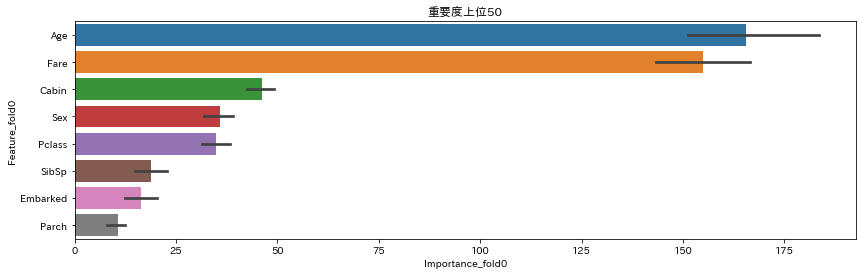

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

train_X_tar = smoothed_target_encoding(train_X, train_y, kf, ["Sex","Cabin", "Embarked"])

best_params = get_bestparams_optuna(train_X_tar, train_y, kf)

lgbm = lgb.LGBMClassifier(**best_params)

pred_train, preds_test, lgbm = predict_cv(lgbm, train_X, train_y, test_X, kf, ["Sex","Cabin", "Embarked"])

In [34]:
sub = pd.read_csv('gender_submission.csv')
sub['Survived'] = preds_test[0].astype(int)
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
#sub.to_csv('optuna_target_encoded.csv', index=None)